# Отчты по данным BSS и OCS
### Отчты по данным BSS
- График по Странам / Кастомерам / TADIG / Sponsor с возможностью задать тип агрегации
- Кастомер, которые выросли с нуля до указанного суммарного профита
- Оценка маркапа
- Отчет по Not discounted uasge

### Отчты по данным OCS
- График по Странам / Кастомерам / TADIG / Sponsor с возможностью задать тип агрегации

## Отчты по данным BSS

In [1]:
# Загрузка библиотек и подготовка переменных

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from os.path import join
import re
import roamability as rb
from collections import namedtuple
import matplotlib.ticker as ticker

register_matplotlib_converters()

plt.style.use('ggplot')

downloads = 'C:/Users/balob/Downloads'
use_value = 'Revenue' # 'Cost', 'Revenue', 'Profit'

sponsor_object = namedtuple('Sponsor', ['name', 'mccmnc', 'sponsor_id'])

s1_sponsor = sponsor_object('S1', 42501, 1)
s2_sponsor = sponsor_object('S2', 26006, 2)
s4_sponsor = sponsor_object('S4', 45403, 4)
s5_sponsor = sponsor_object('S5', 51503, 5)
s6_sponsor = sponsor_object('S6', 26003, 6)
s8_sponsor = sponsor_object('S8', 23450, 8)

sponsors = [s1_sponsor, s2_sponsor, s4_sponsor, s5_sponsor, s6_sponsor, s8_sponsor]

# BSS time range report

start_date = dt.date(2020,7,1) # Including
end_date = dt.date(2020,7,31) # Including

current_date = dt.datetime.now().strftime("%y%m%d")

output_bss_usage_file = f'bss_usage_{start_date}_{end_date}_{current_date}.csv'
output_ocs_usage_file = f"ocs_reseller_charge_{start_date}_{end_date}.csv"

In [2]:
# Получение данных из BSS

sql_srt="""
SELECT * FROM
(
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,'DATA' AS UsageType
FROM aggreg.GPRS_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MOC' WHEN Sms = 1 THEN 'MOSMS' END AS UsageType
FROM aggreg.MOC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MTC' WHEN Sms = 1 THEN 'MTSMS' END AS UsageType
FROM aggreg.MTC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
) t
""".format(start_date=start_date.strftime("%Y%m%d"), end_date=end_date.strftime("%Y%m%d"))

with rb.MySqlConnect('172.18.11.40', 'BSS', 'noc', 'WcQUzkXiXwoxnFfGnRxb') as cnxn:
    df_bss_source = pd.read_sql_query(sql_srt, cnxn)
df_bss_source.to_csv(join(downloads, output_bss_usage_file), index=False)
df_bss_source.head(3)

,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue,UsageType
0,20200701,23450,168,765,172721,0.000014,0.000035,DATA
1,20200701,26006,14,50,172720,0.043960,0.089313,DATA
2,20200701,26006,14,52,172720,1.335600,2.832160,DATA


In [53]:
# Опционально для загрузки из сохраненного ранее файла

# df_bss_source = pd.read_csv(join(downloads, 'bss_usage_20190101_20191130_191220.csv'))
# df_bss_source.head(3)

In [3]:
# Загрузка справочников TADIG и Customers из OCS

sql_srt="""SELECT t.network_id AS VisitedNetworkId, MAX(c.country_name) AS Country, MAX(t.tadig_code) AS Tadig
FROM RDB_TADIG_CODES t
LEFT JOIN RDB_NETWORKS n ON t.network_id = n.network_id
LEFT JOIN RDB_COUNTRIES c ON n.country_id = c.country_id
GROUP BY t.network_id;"""

with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_tadig = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
display(df_tadig.head(3))

sql_srt='SELECT reseller_id AS Customer, reseller_name AS CustomerName FROM RESELLERS;'
with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_customer = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_customer.replace({'STI - Telinta':'STI'}, inplace=True)

display(df_customer.head(3))

,VisitedNetworkId,Country,Tadig
0,4,Afghanistan,AFGAW
1,5,Afghanistan,AFGAR
2,6,Afghanistan,AFGEA


,Customer,CustomerName
0,172711,Mondicon
1,172716,Cloud 9 TAP
2,172717,KnowRoaming IMSI-RANGE TAP


In [4]:
# Подготовка данных и объединение со справочниками

df_bss_processed = df_bss_source.copy()

# Подготовка колонки Profit
df_bss_processed['Profit'] = df_bss_processed['Revenue'] - df_bss_processed['Cost']

# Замена префикса Спонсора на символьное обозначение? S1, S2...
sponsor_dict = dict((sponsor.mccmnc, sponsor.name) for sponsor in sponsors)
df_bss_processed.SponsorPrefix.replace(sponsor_dict, inplace=True)

# Подготовка широкого DF с заданием используемого значения (Cost, Revenue, Profit)
df_bss_processed = df_bss_processed.pivot_table(values=use_value,
                                                index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer'],
                                                columns='UsageType', aggfunc=np.sum).reset_index()

# Обработка значения даты с добавлением дополнительных полей даты
df_bss_processed.Day = pd.to_datetime(df_bss_processed.Day, format='%Y%m%d')
# df_bss_processed['Week'] = df_bss_processed.Day.dt.strftime('%Y-%W')
df_bss_processed['Week'] = df_bss_processed.Day.dt.ceil('7D')
df_bss_processed['Month'] = df_bss_processed.Day.dt.strftime('%Y-%m')

# Объединение с Customer и TADIG
df_bss_processed = pd.merge(df_bss_processed, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')

# Добавление поля TOTAL и выборка используемых в дальнейшем полей
df_bss_processed['TOTAL'] = df_bss_processed[['MOC','MTC','MOSMS','MTSMS','DATA']].sum(axis=1)
df_bss_processed = df_bss_processed[
    ['Day', 'Week','Month','SponsorPrefix','CustomerName','Country','Tadig','MOC','MTC','MOSMS','MTSMS','DATA', 'TOTAL']].fillna(0)

df_bss_processed.head(3)

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
0,2020-07-01,2020-07-02,2020-07,S1,Cloud 9 TAP,Albania,ALBVF,0.0,0.0,0.000,0.0,3.923230,3.923230
1,2020-07-01,2020-07-02,2020-07,S1,Naka TAP,Albania,ALBVF,0.0,0.0,0.168,0.0,0.985953,1.153953
2,2020-07-01,2020-07-02,2020-07,S1,Dialoq - Genesisclub RT,Albania,ALBVF,0.0,0.0,0.000,0.0,0.863965,0.863965


In [5]:
df_bss_processed.groupby(['Month','SponsorPrefix'], as_index=False)['TOTAL'].sum()

,Month,SponsorPrefix,TOTAL
0,2020-07,S1,104348.222419
1,2020-07,S2,12707.974133
2,2020-07,S4,59.149756
3,2020-07,S5,75.359674
4,2020-07,S6,158.323604
5,2020-07,S8,0.006996


In [10]:
df_bss_processed.loc[df_bss_processed.SponsorPrefix == 'S6'].\
groupby(['SponsorPrefix','Country','Tadig'], as_index=False)['TOTAL'].sum().sort_values(by='Tadig')

,SponsorPrefix,Country,Tadig,TOTAL
7,S6,United Arab Emirates,AREDU,153.400470
0,S6,Canada,CANRW,0.089363
1,S6,Costa Rica,CRICR,0.021023
2,S6,Costa Rica,CRITC,0.588329
3,S6,Germany,DEUD1,1.866667
6,S6,Spain,ESPVV,0.108862
8,S6,United Kingdom,GBRCN,0.533355
9,S6,United Kingdom,GBRVF,0.019482
4,S6,Russian Federation,RUS01,1.656155
5,S6,Russian Federation,RUSNW,0.039898


In [12]:
df_bss_processed.loc[df_bss_processed.SponsorPrefix=='S4'].groupby(['Month','SponsorPrefix'], as_index=False)['TOTAL'].sum()

,Month,SponsorPrefix,TOTAL
0,2020-05,S4,55.005281
1,2020-06,S4,21.803377
2,2020-07,S4,12.961655


#### График по Странам / Кастомерам / TADIG / Sponsor с возможностью задать параметр агрегации

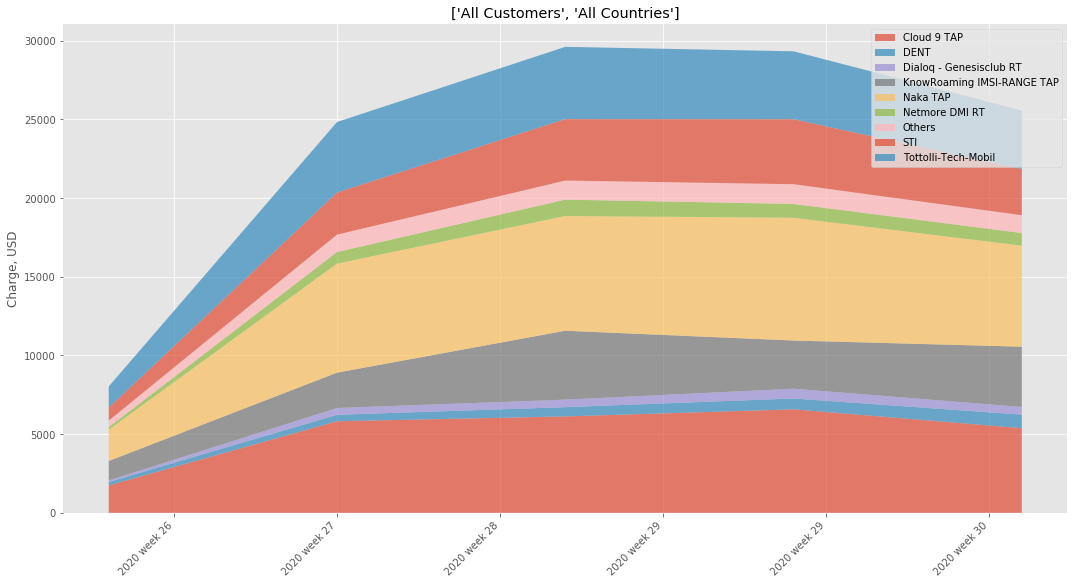

In [14]:
threshold = 500 # Ниже данного порога (USD) значение будет попадать в Other
aggregation_type = 'CustomerName' # CustomerName, Country, Tadig, SponsorPrefix

customer = '' # Define the Customer with regular expression or leave ''
country = ''
# Define the Country with regular expression or leave ''

df_temp = df_bss_processed[
    (df_bss_processed.CustomerName.str.contains(customer, na=False, regex=True, flags=re.I)) &
#     (df_bss_processed.CustomerName.isin(customer)) &
    (df_bss_processed.Country.str.contains(country, na=False, regex=True, flags=re.I))
].copy()

if customer:
    customer = [value for value in set(df_temp.CustomerName.to_list())]
else:
    customer = ['All Customers']
    
if country:
    country = [value for value in set(df_temp.Country.to_list())]
else:
    country = ['All Countries']
    
plot_name = customer + country
    
s1 = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()\
.groupby([aggregation_type])['TOTAL'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed[aggregation_type].isin(list_other), [aggregation_type]] = 'Others'

df_temp = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()

df_temp = df_temp.pivot_table(values='TOTAL',index=['Week']
                   ,columns=aggregation_type, aggfunc=np.sum).reset_index().sort_values(by='Week')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Week'].values, df_temp.drop('Week', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper right')
ax.set_ylabel('Charge, USD')
plt.xticks(rotation=45, ha="right")

# Удалить рамку графика
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title(plot_name) #Задать название графика

date_format = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    
plt.show()

In [9]:
# For Dent
df_temp.to_csv(join(downloads,'CostReport200724.csv'), index=False)

#### Кастомер, которые выросли с нуля до указанного суммарного профита

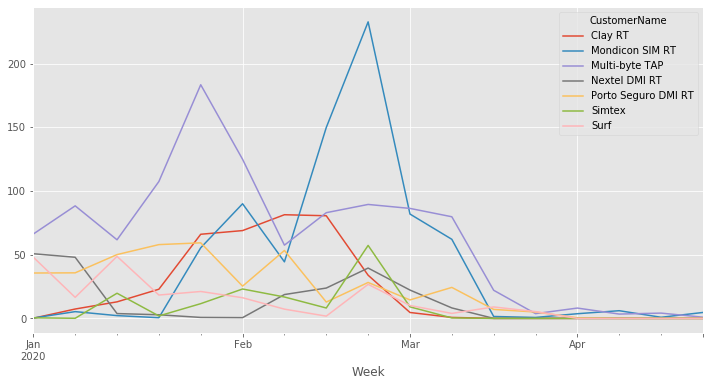

In [6]:
# Summary value
sum_value = 100

# Не учитывать:
exclude_customers = ['Telzar 019 DMI RT', 'TinkLabs  RT']

df_temp = df_bss_processed.groupby(['Week','CustomerName'],as_index=False)['TOTAL'].sum()\
.groupby('CustomerName')['TOTAL'].agg([('ProfitMin', np.min), ('ProfitSum', np.sum)]).reset_index()

df_temp = df_temp[~df_temp.CustomerName.isin(exclude_customers)]

list_breakthrough = df_temp[(df_temp.ProfitMin < 1) & (df_temp.ProfitSum > sum_value)].CustomerName.tolist()

df_bss_processed[df_bss_processed.CustomerName.isin(list_breakthrough)].pivot_table(values='TOTAL',index=['Week']
                   ,columns='CustomerName', aggfunc=np.sum).reset_index().sort_values(by='Week').fillna(0).set_index('Week')\
.plot(figsize=(12,6))
plt.show()

### Оценка маркапа

In [5]:
# Подготовка данных

df_bss = df_bss_source.copy()
sponsor_dict = dict((sponsor.mccmnc, sponsor.name) for sponsor in sponsors)
df_bss.SponsorPrefix.replace(sponsor_dict, inplace=True)
df_bss = df_bss.pivot_table(values=['Cost','Revenue'],index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer']
                   ,columns='UsageType', aggfunc=np.sum).reset_index()
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')

df_bss.columns = [''.join(col) for col in df_bss.columns]

df_bss = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss = pd.merge(df_bss, df_tadig, how='left', on='VisitedNetworkId')
# df_bss_processed['Month'] = df_bss_processed.Day.dt.strftime('%Y-%m')
df_bss = df_bss[
    ['Day','SponsorPrefix','CustomerName','Tadig'
     ,'CostMOC','RevenueMOC','CostMTC','RevenueMTC'
     ,'CostMOSMS','RevenueMOSMS','CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA']].fillna(0)
df_bss.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
0,2020-07-01,S1,Cloud 9 TAP,ALBVF,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,1.961740,3.923230
1,2020-07-01,S1,Naka TAP,ALBVF,0.0,0.0,0.0,0.0,0.083167,0.168,0.0,0.0,0.492370,0.985953
2,2020-07-01,S1,Dialoq - Genesisclub RT,ALBVF,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.431998,0.863965


In [7]:
# Выборака данных Кастомеру

markup_rel_tolerance = 0 # 1 - 100% от Chgarge Example: Cost = 10 USD, Charge < 10 USD
cost_tolerance = 1 # USD

customer = ''
sponsor = 'S6'
# start_date = '2020-01-01' # including
# end_date = '2020-02-01' # including
# start_date = rep_date_start.strftime('%Y-%m-%d') # including
# end_date = rep_date_end.strftime('%Y-%m-%d') # including

output_diff_file = f'bss_tariff_diff_{start_date}_{end_date}_{current_date}.xlsx'

df_temp = df_bss.copy()

if customer:
    df_temp = df_temp.loc[df_temp.CustomerName == customer]

if sponsor:
    df_temp = df_temp.loc[df_temp.SponsorPrefix == sponsor]
    
if start_date and end_date:
    df_temp = df_temp[(df_temp.Day >= start_date.strftime('%Y-%m-%d')) & (df_temp.Day <= end_date.strftime('%Y-%m-%d'))]

df_temp = df_temp.groupby(
        ['SponsorPrefix','Tadig'], as_index=False).sum()

# df_diff = df_temp[
#     ~np.isclose(df_temp.CostMOC * 2, df_temp.RevenueMOC, rtol=markup_rel_tolerance, equal_nan=True) |\
#     ~np.isclose(df_temp.CostMTC * 2, df_temp.RevenueMTC, rtol=markup_rel_tolerance, equal_nan=True) |\
#     ~np.isclose(df_temp.CostMOSMS * 2, df_temp.RevenueMOSMS, rtol=markup_rel_tolerance, equal_nan=True) |\
#     ~np.isclose(df_temp.CostMTSMS * 2, df_temp.RevenueMTSMS, rtol=markup_rel_tolerance, equal_nan=True) |\
#     ~np.isclose(df_temp.CostDATA * 2, df_temp.RevenueDATA, rtol=markup_rel_tolerance, equal_nan=True)
# ]

df_diff = df_temp[
    (~np.isclose(df_temp.CostMOC * 2, df_temp.RevenueMOC, rtol=markup_rel_tolerance, equal_nan=True) &
     (df_temp.CostMOC > cost_tolerance)) |\
    (~np.isclose(df_temp.CostMTC * 2, df_temp.RevenueMTC, rtol=markup_rel_tolerance, equal_nan=True) &
     (df_temp.CostMTC > cost_tolerance)) |\
    (~np.isclose(df_temp.CostMOSMS * 2, df_temp.RevenueMOSMS, rtol=markup_rel_tolerance, equal_nan=True) &
     (df_temp.CostMOSMS > cost_tolerance)) |\
    (~np.isclose(df_temp.CostMTSMS * 2, df_temp.RevenueMTSMS, rtol=markup_rel_tolerance, equal_nan=True) &
     (df_temp.CostMTSMS > cost_tolerance)) |\
    (~np.isclose(df_temp.CostDATA * 2, df_temp.RevenueDATA, rtol=markup_rel_tolerance, equal_nan=True) &
     (df_temp.CostDATA > cost_tolerance))
]

def colorize(s):
    color_list = []
    for tariff_type in [['CostMOC','RevenueMOC'], ['CostMTC','RevenueMTC'],
                        ['CostMOSMS','RevenueMOSMS'], ['CostMTSMS','RevenueMTSMS'], ['CostDATA','RevenueDATA']]:
        if np.isclose(s[tariff_type[0]] * 2, s[tariff_type[1]], rtol=markup_rel_tolerance, equal_nan=True):
            color_list.extend(['', ''])
        elif s[tariff_type[0]] * 2 > s[tariff_type[1]]:
            color_list.extend(['background-color: yellow', 'background-color: red'])
        else:
            color_list.extend(['background-color: yellow', 'background-color: #81EF21'])
    return color_list

df_diff_style = df_diff.style.apply(colorize,
                            subset=['CostMOC','RevenueMOC','CostMTC','RevenueMTC','CostMOSMS','RevenueMOSMS',
                                    'CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA'], axis=1).hide_index()

display(df_diff_style)
df_diff_style.to_excel(join(downloads, output_diff_file), index=False)

SponsorPrefix,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
S6,AREDU,28.2643,57.4457,0,0,0,0,0,0,47.2172,95.9548


### Отчет по Not discounted uasge

In [8]:
# Выгрузить TADIG NOT discounted сетей из OCS

sql_srt="""SELECT t.tadig_code AS Tadig,r.sponsor_id as SponsorPrefix FROM ROAMING_PLAN_RULES r
LEFT JOIN RDB_TADIG_CODES t
ON r.network_id=t.network_id
LEFT JOIN ROAMING_PLANS p
ON r.roaming_plan_id=p.roaming_plan_id
WHERE r.roaming_plan_id IN (267,268,329,343,368,372)
--AND r.SPONSOR_ID = 2
AND p.deleted IS NULL
AND ((r.start_date < GETDATE() AND r.end_date is null) OR (r.start_date < GETDATE() AND r.end_date > GETDATE()))
AND is_discounted = 0;"""

with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_not_disc = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_not_disc.replace(dict([sponsor.sponsor_id, sponsor.name] for sponsor in sponsors), inplace=True)
display(df_not_disc.head(3))

,Tadig,SponsorPrefix
0,AFG55,S6
1,ANDMA,S1
2,AGOMV,S1


In [10]:
# Получение usage в NOT discounted сетях

threshold = 1

customer = ''
sponsor = ''
# start_date = '2020-01-01' # including
# end_date = '2020-02-01' # excluding
output_diff_file = f'bss_not_disc_{start_date}_{end_date}_{current_date}.xlsx'

df_bss_not_disc = pd.merge(df_bss_processed, df_not_disc, how='inner', on=['Tadig','SponsorPrefix'])

if customer:
    df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.CustomerName == customer]

if sponsor:
    df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.SponsorPrefix == sponsor]
    
if start_date and end_date:
    df_bss_not_disc = df_bss_not_disc[(df_bss_not_disc.Day >= start_date.strftime('%Y-%m-%d'))
                                      & (df_bss_not_disc.Day <= end_date.strftime('%Y-%m-%d'))]

df_bss_not_disc = df_bss_not_disc.groupby(['Month','SponsorPrefix','CustomerName','Country','Tadig'], as_index=False).sum()
df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.TOTAL > threshold]
df_bss_not_disc.to_excel(join(downloads, output_diff_file), index=False)
df_bss_not_disc

,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL


### Сделать:
- Распределение трафика по типу (data/moc/mtc)

## Отчты по данным OCS

In [16]:
# Get data from OCS DB и Подготовка данных

sql_srt = """
SELECT
CONVERT(VARCHAR(10), u.USAGE_DATE, 103) AS Day
,s.DISPLAY_NAME AS SponsorPrefix
,mm.NETWORK_ID AS VisitedNetworkId
,r.RESELLER_ID AS Customer
,SUM(uc.COST) AS Cost
,SUM(uc.CHARGE) AS Revenue
,ut.USAGE_TYPE AS UsageType
,MIN(uc.BALANCE) AS BALANCE
FROM [10028_usage].dbo.usage u
INNER JOIN [10028_usage].dbo.USAGE_CHARGES uc ON u.USAGE_ID = uc.USAGE_ID
INNER JOIN [10028].dbo.USAGE_TYPE ut ON u.USAGE_TYPE = ut.USAGE_TYPE_ID
INNER JOIN [10028].dbo.RESELLERS r ON uc.ACCOUNT_ID = r.ACCOUNT_ID
INNER JOIN [10028].dbo.RDB_NETWORK_IMSI_PREFIXES mm ON u.MCC = mm.MCC AND u.MNC = mm.MNC
INNER JOIN [10028].dbo.SPONSORS s ON u.GUIDING_INFO LIKE CONCAT(s.IMSI_PREFIX, '%')
WHERE
uc.CHARGE_ENTITY_TYPE = 'Reseller'
AND u.usage_date BETWEEN '{start_date}' AND '{end_date}'
GROUP BY
CONVERT(VARCHAR(10), u.USAGE_DATE, 103)
,ut.USAGE_TYPE
,r.RESELLER_ID
,r.RESELLER_NAME
,mm.NETWORK_ID
,s.DISPLAY_NAME""".format(start_date = start_date.strftime('%Y-%m-%d %H:%M:%S'),
                          end_date = (end_date + pd.Timedelta('1D')).strftime('%Y-%m-%d %H:%M:%S'))

with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_ocs_source = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_ocs_source.replace({'Data':'DATA','Incoming Text':'MTSMS','Outgoing Call':'MOC','Outgoing Text':'MOSMS'}, inplace=True)
    
# Подготовка данных

df_ocs_processed = df_ocs_source.copy()

# Подготовка колонки Profit
df_ocs_processed['Profit'] = df_ocs_processed['Revenue'] - df_ocs_processed['Cost']

# Подготовка широкого DF с заданием используемого значения (Cost, Revenue, Profit)
df_ocs_processed = df_ocs_processed.pivot_table(values=use_value,
                                                index=['Day','SponsorPrefix','VisitedNetworkId','Customer'],
                                                columns='UsageType', aggfunc=np.sum).reset_index()

# Обработка значения даты с добавлением дополнительных полей даты
df_ocs_processed.Day = pd.to_datetime(df_ocs_processed.Day, format='%d/%m/%Y')
df_ocs_processed['Month'] = df_ocs_processed.Day.dt.strftime('%Y-%m')
df_ocs_processed['Week'] = df_ocs_processed.Day.dt.ceil('7D')

# Добавление поля TOTAL и выборка используемых в дальнейшем полей
df_ocs_processed['TOTAL'] = df_ocs_processed[['MOC','MOSMS','MTSMS','DATA']].sum(axis=1)
df_ocs_processed['MTC'] = 0
usage_type_names = ['MOC','MTC','MOSMS','MTSMS','DATA', 'TOTAL']
df_ocs_processed[usage_type_names] = df_ocs_processed[usage_type_names].astype('float64')

# Объединение с Customer и TADIG
df_ocs_processed = pd.merge(df_ocs_processed, df_customer, how='left', on='Customer')
df_ocs_processed = pd.merge(df_ocs_processed, df_tadig, how='left', on='VisitedNetworkId')

df_ocs_processed = df_ocs_processed[
    ['Day', 'Week','Month','SponsorPrefix','CustomerName','Country','Tadig','MOC','MTC','MOSMS','MTSMS','DATA', 'TOTAL']].fillna(0)

df_ocs_processed.to_csv(join(downloads, output_ocs_usage_file), index=False)

df_ocs_processed.head(3)

,Day,SponsorPrefix,VisitedNetworkId,Customer,DATA,MOC,MOSMS,MTSMS,VOIP Incoming Call,VOIP Outgoing Call,Month,Week,TOTAL,MTC,CustomerName,Country,Tadig
0,2020-07-01,S1,12,172794,0.86656,NaN,NaN,NaN,NaN,NaN,2020-07,2020-07-02,0.86656,0.0,Dialoq - Genesisclub RT,Albania,ALBVF
1,2020-07-01,S1,12,172844,1.66295,0.059,NaN,NaN,0.00000,0.00000,2020-07,2020-07-02,1.72195,0.0,Tottolli-Tech-Mobil,Albania,ALBVF
2,2020-07-01,S1,45,172844,0.00016,0.489,NaN,NaN,NaN,0.00000,2020-07,2020-07-02,0.48916,0.0,Tottolli-Tech-Mobil,Australia,AUSOP


In [25]:
df_ocs_processed.loc[(df_ocs_processed.SponsorPrefix == 'S6') & (df_ocs_processed.Tadig == 'PSEWM')]

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
381,2020-07-01,2020-07-02,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,38.40954,0.0,0.0,0.0,0.90429,39.31383
740,2020-07-02,2020-07-02,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.00000,0.0,0.0,0.0,0.43720,0.43720
1103,2020-07-03,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.00000,0.0,0.0,0.0,0.53935,0.53935
1451,2020-07-04,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.00000,0.0,0.0,0.0,0.71478,0.71478
1810,2020-07-05,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.00000,0.0,0.0,0.0,0.21925,0.21925
2158,2020-07-06,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.25116,0.0,0.0,0.0,5.93493,6.18609
2524,2020-07-07,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.00000,0.0,0.0,0.0,1.04279,1.04279
2901,2020-07-08,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,40.79556,0.0,0.0,0.0,1.53909,42.33465
3271,2020-07-09,2020-07-09,2020-07,S6,FirstPoint,Palestinian Territory,PSEWM,0.08073,0.0,0.0,0.0,0.20081,0.28154


In [20]:
df_ocs_processed.loc[df_ocs_processed.SponsorPrefix == 'S6'].\
groupby(['SponsorPrefix','Country','Tadig'], as_index=False)['TOTAL'].sum().sort_values(by='Country')

,SponsorPrefix,Country,Tadig,TOTAL
0,S6,Canada,CANBM,2.52685
1,S6,Canada,CANRW,0.09926
2,S6,Canada,CANTS,0.11847
3,S6,Costa Rica,CRICL,1.64349
4,S6,Costa Rica,CRICR,3.09954
5,S6,Costa Rica,CRITC,0.68659
6,S6,Germany,DEUD1,41.49945
7,S6,Germany,DEUD2,0.52667
8,S6,Germany,DEUO2,1.47723
9,S6,Israel,ISRCL,2.48027


### Developments

In [19]:
df_bss_processed.loc[df_bss_processed.Day>'2020-02-01']
# df_bss_processed.dtypes

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
28235,2020-02-02,2020-02-06,2020-02,S1,Cloud 9 TAP,Albania,ALBVF,0.078000,0.0,0.0,0.0,2.726400,2.804400
28236,2020-02-02,2020-02-06,2020-02,S1,KnowRoaming IMSI-RANGE TAP,Albania,ALBVF,0.000000,0.0,0.0,0.0,0.170244,0.170244
28237,2020-02-02,2020-02-06,2020-02,S1,Tottolli-Tech-Mobil,Albania,ALBVF,0.766000,0.0,0.0,0.0,0.000000,0.766000
28238,2020-02-02,2020-02-06,2020-02,S1,Drimsim,Albania,ALBVF,0.000000,0.0,0.0,0.0,0.140269,0.140269
28239,2020-02-02,2020-02-06,2020-02,S1,Cloud 9 TAP,Argentina,ARGTM,0.000000,0.0,0.0,0.0,1.780620,1.780620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113653,2020-05-30,2020-06-04,2020-05,S4,Drimsim,Thailand,THAWN,0.000000,0.0,0.0,0.0,0.000352,0.000352
113654,2020-05-30,2020-06-04,2020-05,S4,Dialoq - Genesisclub RT,United Arab Emirates,AREDU,0.000000,0.0,0.0,0.0,0.001169,0.001169
113655,2020-05-30,2020-06-04,2020-05,S4,Tottolli-Tech-Mobil,United Arab Emirates,AREDU,0.000000,0.0,0.0,0.0,0.656522,0.656522
113656,2020-05-30,2020-06-04,2020-05,S5,Drimsim,France,FRAF1,0.013225,0.0,0.0,0.0,0.000000,0.013225


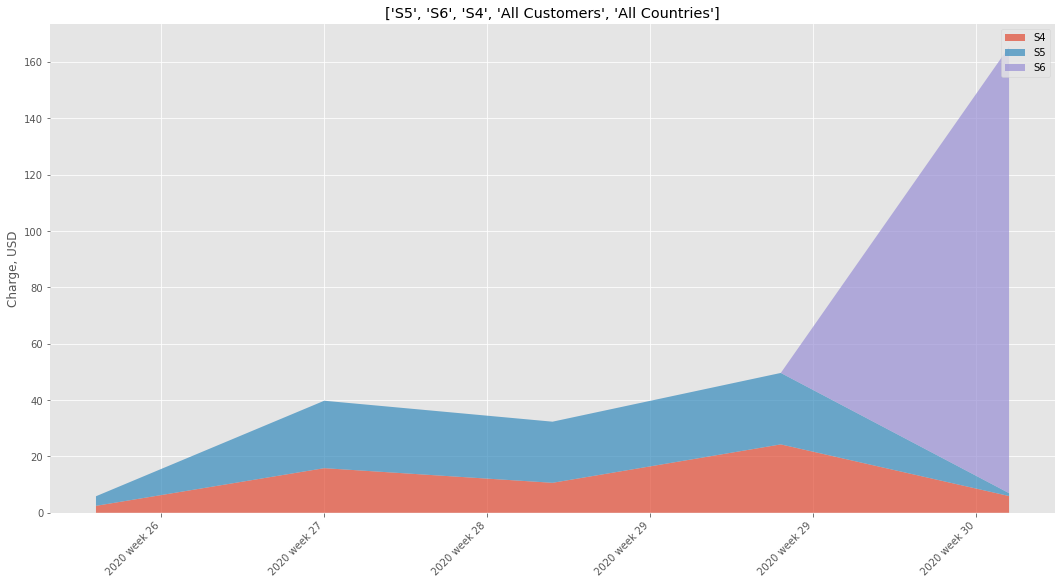

In [72]:
threshold = 1 # Ниже данного порога (USD) значение будет попадать в Other
aggregation_type = 'SponsorPrefix' # CustomerName, Country, Tadig, SponsorPrefix

customer = '' # Define the Customer with regular expression or leave ''
country = ''
sponsor = 'S[4,5,6]'

# Define the Country with regular expression or leave ''

df_temp = df_bss_processed[
    (df_bss_processed.CustomerName.str.contains(customer, na=False, regex=True, flags=re.I)) &
    (df_bss_processed.SponsorPrefix.str.contains(sponsor, na=False, regex=True, flags=re.I)) &
    (df_bss_processed.Country.str.contains(country, na=False, regex=True, flags=re.I))
].copy()

if sponsor:
    sponsor = [value for value in set(df_temp.SponsorPrefix.to_list())]
else:
    sponsor = ['All Sponsors']

if customer:
    customer = [value for value in set(df_temp.CustomerName.to_list())]
else:
    customer = ['All Customers']
    
if country:
    country = [value for value in set(df_temp.Country.to_list())]
else:
    country = ['All Countries']
    
plot_name = sponsor + customer + country
    
s1 = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()\
.groupby([aggregation_type])['TOTAL'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed[aggregation_type].isin(list_other), [aggregation_type]] = 'Others'

df_temp = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()

df_temp = df_temp.pivot_table(values='TOTAL',index=['Week']
                   ,columns=aggregation_type, aggfunc=np.sum).reset_index().sort_values(by='Week')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Week'].values, df_temp.drop('Week', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper right')
ax.set_ylabel('Charge, USD')
plt.xticks(rotation=45, ha="right")

# Удалить рамку графика
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title(plot_name) #Задать название графика

date_format = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    
plt.show()

In [29]:
df_ocs_report = df_ocs_processed.loc[df_ocs_processed.SponsorPrefix == 'S6'].\
groupby(['SponsorPrefix','Country','Tadig'], as_index=False)['TOTAL'].sum().sort_values(by='Country')
df_ocs_report.head()

,SponsorPrefix,Country,Tadig,TOTAL
0,S6,Canada,CANBM,2.52685
1,S6,Canada,CANRW,0.09926
2,S6,Canada,CANTS,0.11847
3,S6,Costa Rica,CRICL,1.64349
4,S6,Costa Rica,CRICR,3.09954


In [30]:
df_bss_report = df_bss_processed.loc[df_bss_processed.SponsorPrefix == 'S6'].\
groupby(['SponsorPrefix','Country','Tadig'], as_index=False)['TOTAL'].sum().sort_values(by='Tadig')
df_bss_report.head()

,SponsorPrefix,Country,Tadig,TOTAL
7,S6,United Arab Emirates,AREDU,153.400470
0,S6,Canada,CANRW,0.089363
1,S6,Costa Rica,CRICR,0.021023
2,S6,Costa Rica,CRITC,0.588329
3,S6,Germany,DEUD1,1.866667


In [43]:
df_temp.head()

,SponsorPrefix,Country,Tadig,TOTALOcs,TOTALBss
0,S6,Canada,CANBM,2.52685,NaN
1,S6,Canada,CANRW,0.09926,0.089363
2,S6,Canada,CANTS,0.11847,NaN
3,S6,Costa Rica,CRICL,1.64349,NaN
4,S6,Costa Rica,CRICR,3.09954,0.021023


In [62]:
df_temp = pd.merge(df_ocs_report, df_bss_report, how='outer', on=['SponsorPrefix','Country','Tadig'],
                   suffixes=['Ocs', 'Bss'])
df_temp['OCS'] = df_temp.TOTALOcs.map(lambda x: 'Y' if x > 0 else 'N')
df_temp['BSS'] = df_temp.TOTALBss.map(lambda x: 'Y' if x > 0 else 'N')
df_temp[['SponsorPrefix','Country','Tadig','OCS','BSS']].to_csv(join(downloads, 'S6_OCS_BSS.csv'), index=False)